Passive Models Research
-------------------------
### Current Models:

   - #### Minimize Volatility Model.
    
   - #### OLS Model.
    
   - #### Factor Dynamic Adjustment Model.
    
   - #### Time-Variant OLS Model.

### Canidate Models:

   - #### Lasso OLS: only use the factor that is usful.

### Performace Evaluation:

   - #### How fast the weight adjustment ?
   
   - #### If accumulated Return close to zero ?
   
   - #### If the return volatile ?

### Extension Project:
   - #### Dynamic Estimating Correlation Matix.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2
from akira.models.baskets.src.passive_model import FactorDynamicBasketModel, DCCGARCH
from statsmodels.tools.tools import add_constant
from scipy.stats import norm
from matplotlib.lines import Line2D
import pickle as pkl
from pandas.tseries.offsets import MonthOffset

In [2]:
# Features transform
# Percentile score
def percentile_score(x, window_size):
    all_ = []
    for i in range(window_size, x.shape[0]):
        rows = []
        for j in range(x.shape[1]):
            rows.append(stats.percentileofscore(x.iloc[:i, j], x.iloc[i, j]))
        all_.append(rows)
    res = pd.DataFrame(np.array(all_)/100, index=x.index[window_size:], columns=x.columns)
    return res

# Chi-Square Transform
def chi2normal_transformation(df):
    risk_factor = pd.DataFrame(chi2.cdf(df, pd.rolling_mean(df, 150)), columns=df.columns, index=df.index)
    risk_factor = (risk_factor - pd.expanding_mean(risk_factor))/pd.expanding_std(risk_factor)
    return risk_factor

In [4]:
# model daily fx rate
with open("../sythesis/excels/EWS_MAIN.xlsx", "rb") as f:
    modeldaily_fx_rate = pd.read_excel(f, sheet_name="FX_RATE").dropna()
    modeldaily_fx_rate.set_index("DATE", 1, inplace=True)

with open("./pkls/curncy_vix.pkl", "rb") as f:
    curncy_vix = pkl.load(f, encoding="latin1")
    curncy_vix.columns = curncy_vix.columns.levels[0][curncy_vix.columns.labels[0]]
    
with open("./pkls/basket_data.pkl", "rb") as f:
    basket_data = pkl.load(f, encoding="latin1")

FileNotFoundError: [Errno 2] No such file or directory: '../sythesis/excels/EWS_MAIN.xlsx'

In [3]:
from akira.data.bbg import BBGapiClient
con = BBGapiClient()

In [4]:
from akira.data.bbg import all_dataset

In [5]:
data = all_dataset['basket_vol']()

In [6]:
vol = list(data.make_all_tickers())

In [7]:
ccy = ["USDTWD CMPT Curncy", "EURUSD CMPT Curncy", "USDKRW CMPT Curncy", "USDSGD CMPT Curncy", 
       "AUDUSD CMPT Curncy", "GBPUSD CMPT Curncy"]
spot = con.bdh(ccy, ["PX_MID", "PX_LAST", "PX_OPEN", "PX_LOW"], "20000101", "20191016")

In [8]:
class FXRateDataFrame(pd.DataFrame):
    def to_x_based(self):
        m = self.copy()
        columns = []
        for c in self.columns:
            field = c[1]
            symbol = c[0].split()[0]
            a = symbol[:3]
            b = symbol[3:]
            if a == "USD":
                m[c] = 1/m[c]
                symbol = b + a            
            columns.append((symbol, field))
        m.columns = pd.MultiIndex.from_tuples(columns)
        return m

In [9]:
fx_rate = FXRateDataFrame(spot).to_x_based()
fx_rate.index = pd.DatetimeIndex(fx_rate.index)

In [10]:
fx_return = fx_rate.pct_change() * 100

In [11]:
garch = DCCGARCH()

In [17]:
fx_rate_return_mid = fx_return.xs("PX_MID", axis=1, level=1).dropna()

In [18]:
fx_rate_return_mid

,TWDUSD,EURUSD,KRWUSD,SGDUSD,AUDUSD,GBPUSD
date,,,,,,
2000-01-04,2.655678,1.631241,0.493215,0.262975,0.182551,1.291958
2000-01-05,-0.614334,0.846304,-1.092643,-0.060417,-0.091109,0.164775
2000-01-06,-0.257744,-0.144690,-1.057069,-0.516905,-0.265978,0.316822
2000-01-07,-0.011346,-0.454019,0.881310,0.084218,-0.281926,-0.091102
2000-01-10,0.074615,-0.601650,0.280778,0.165703,0.343853,-0.419453
2000-01-11,0.021091,0.585766,-0.636839,-0.592992,-0.327444,0.347964
2000-01-12,-0.017843,0.330001,-0.310777,0.255217,0.649400,0.212921
2000-01-13,0.061678,-0.338590,0.629873,-0.113967,0.918476,-0.139622
2000-01-14,-0.136156,-0.417395,1.120192,-0.370514,0.142911,0.024316


In [22]:
fx_rate_return_mid.cov()

,TWDUSD,EURUSD,KRWUSD,SGDUSD,AUDUSD,GBPUSD
TWDUSD,0.073120,0.065055,0.101554,0.054221,0.095591,0.058573
EURUSD,0.065055,0.374752,0.140158,0.120712,0.275974,0.232275
KRWUSD,0.101554,0.140158,0.422051,0.125206,0.266324,0.137339
SGDUSD,0.054221,0.120712,0.125206,0.105773,0.158101,0.098000
AUDUSD,0.095591,0.275974,0.266324,0.158101,0.614669,0.247017
GBPUSD,0.058573,0.232275,0.137339,0.098000,0.247017,0.347711


In [42]:
garch.fit(fx_rate_return_mid)

<class 'pandas.core.frame.DataFrame'> from python: 
               TWDUSD    EURUSD    KRWUSD    SGDUSD    AUDUSD    GBPUSD
date                                                                  
2000-01-04  2.655678  1.631241  0.493215  0.262975  0.182551  1.291958
2000-01-05 -0.614334  0.846304 -1.092643 -0.060417 -0.091109  0.164775
2000-01-06 -0.257744 -0.144690 -1.057069 -0.516905 -0.265978  0.316822
2000-01-07 -0.011346 -0.454019  0.881310  0.084218 -0.281926 -0.091102
2000-01-10  0.074615 -0.601650  0.280778  0.165703  0.343853 -0.419453


R object with classes: ('list',) mapped to:
<ListVector - Python:0x000001E92B8CFE88 / R:0x000001E9150415F0>
[Matrix, Matrix, Matrix, ListVector, ..., FloatVector, FloatVector, BoolVector, RS4]
  Bcoef: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x000001E9256A9348 / R:0x000001E9299C15B8>
[-0.071583, -0.001550, 0.028629, -0.021890, ..., 0.000863, 0.004477, 0.003653, -0.002664]
  xfitted: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x000001E97BDE8F88 / R:0x000001E92253AC60>
[0.000221, -0.142851, 0.030429, -0.015555, ..., 0.000405, 0.178123, -0.002186, 0.062431]
  xresiduals: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x000001E9255F7848 / R:0x000001E928FCC448>
[2.655457, -0.471484, -0.288174, 0.004209, ..., 2.556474, -0.202011, 0.777942, 0.637014]
R object with classes: ('list',) mapped to:
<ListVector - Python:0x000001E92B8CFE88 / R:0x000001E9150415F0>
[Matrix, Matrix, Matrix, ListVector, ..., FloatVector, FloatVector, BoolVector, RS4]
...
  tstat: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x000001E92B9F7D48 / R:0x000001E91D672F48>
[1.000000]
  pstat: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x000001E92B9F7A08 / R:0x000001E915990BE0>
[0.000000]
  lag: <class 'rpy2.robjects.vectors.BoolVector'>
  R object with classes: ('logical',) mapped to:
<BoolVector - Python:0x000001E92B9F7988 / R:0x000001E913F294F8>
[       1]
  mxn: <class 'rpy2.robjects.methods.RS4'>
  R object with classes: ('DCCfit',) mapped to:
<RS4 - Python:0x000001E9255F7D08 / R:0x000001E915E92C48>

In [ ]:
garch

In [44]:
garch.result[-1]

R object with classes: ('DCCfit',) mapped to:
<RS4 - Python:0x000001E92B74B088 / R:0x000001E915E92C48>

In [47]:
import rpy2.robjects as robjects
rcov = robjects.r("rcov")
rcor = robjects.r("rcor")
cov = np.array(rcov(garch.result[-1]))
cor = np.array(rcor(garch.result[-1]))

In [63]:
all_cov = []
for k, id_ in enumerate(fx_rate_return_mid.index):
    c = pd.DataFrame(cov[:, :, k], columns=fx_rate_return_mid.columns, 
             index=pd.MultiIndex.from_tuples([(id_, i) for i in fx_rate_return_mid.columns]))
    all_cov.append(c)
cov_all = pd.concat(all_cov, axis=0)

In [65]:
cov_all = pd.concat(all_cov, axis=0)

In [ ]:
all_cov = []
for k, id_ in enumerate(fx_rate_return_mid.index):
    c = pd.DataFrame(cov[:, :, k], columns=fx_rate_return_mid.columns, 
             index=pd.MultiIndex.from_tuples([(id_, i) for i in fx_rate_return_mid.columns]))
    all_cov.append(c)

In [69]:
all_cor = []
for k, id_ in enumerate(fx_rate_return_mid.index):
    c = pd.DataFrame(cor[:, :, k], columns=fx_rate_return_mid.columns, 
             index=pd.MultiIndex.from_tuples([(id_, i) for i in fx_rate_return_mid.columns]))
    all_cor.append(c)

In [70]:
cor_all = pd.concat(all_cor, axis=0)

In [71]:
import pickle as pkl
with open(u"//Cxlsvr624/外匯共用/_Bloomberg_NEW/Eugene/Bloomberg_api/mgarch/mgarch_basket.cor.20191017.pkl", "wb") as f:
    pkl.dump(cor_all, f)

In [ ]:
from akira.db.currency import CurrencyDataFrame

In [16]:
vol = con.bdh(vol, ["PX_MID", "PX_LAST", "PX_OPEN", "PX_LOW"], "20000101", "20191016")

In [19]:
import pickle as pkl
with open("//Cxlsvr624/外匯共用/_Bloomberg_NEW/William/Python/Data/fx_tw_hedgingcost.pkl", "rb") as f:
    df = pkl.load(f, encoding="latin01")

In [24]:
interest = all_dataset["zero_coupon"]()

In [25]:
interest

In [29]:
ndf = con.bdh(["NTN+1M Curncy", "USDTWD CMPT Curncy"], "PX_MID", "20000101", "20191016")

In [32]:
cost = ((ndf["NTN+1M Curncy"]/ndf["USDTWD CMPT Curncy"]) - 1)

In [33]:
cost.index = pd.to_datetime(cost.index)

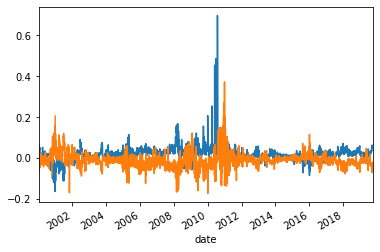

In [36]:
df["NDF-1s"].plot()
(cost["PX_MID"]*12).plot()

In [23]:
workday_index = modeldaily_fx_rate.index
basket_data.columns = [i.replace(" Curncy", "").replace("USD", "") 
                       for i in basket_data.columns.levels[0][basket_data.columns.labels[0]]]

In [24]:
m = basket_data.loc[workday_index].dropna()
p = ["EUR", "GBP", "NZD", "AUD"]

for i in m.columns:
    if i not in p:
        m[i] = 1./m[i]

monthly_return = m[m.index > pd.to_datetime("20090101")].resample("BMS").apply(
    lambda x: (x.iloc[-1] - x.iloc[0])/x.iloc[0])

# change TWD into USD
monthly_return["TWD"] = - monthly_return["TWD"] 
monthly_return.rename(columns={"TWD": "USD"}, inplace=True)
currency_vix = curncy_vix

In [25]:
modeldaily_fx_rate = modeldaily_fx_rate[basket_data.columns.tolist()]

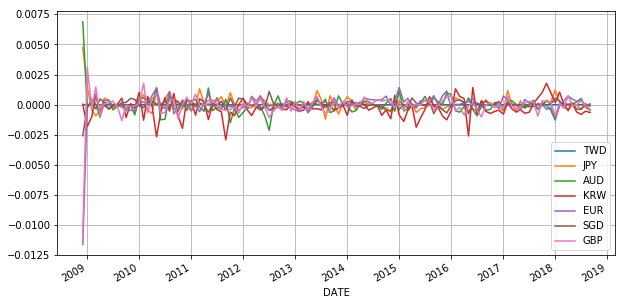

In [26]:
((modeldaily_fx_rate - basket_data.loc[workday_index])/modeldaily_fx_rate).resample("BMS").apply(
    lambda x: (x.mean())).plot(figsize=(10, 5), grid=True)

In [50]:
# Perparse dataset
# loading data
excel_pd = basket_data.copy()# .loc[workday_index].dropna()
currency_vix = curncy_vix

# seting plot
meta_setup = {"figsize":(15, 5), "grid": True}

# select valid data
data = excel_pd

# Prepare the factors
# forward shift the factors for one week
all_vix = currency_vix
all_vix = all_vix.shift(1) # lag information
sigma_vix = ['VIX Index'] + \
    [col for col in all_vix.columns if "V1M" in col] # Factor Names
x_base_cncy = ["USD", "AUD", "EUR", "GBP"]
portfolio = ["JPY", "AUD", "KRW", "EUR", "SGD", "GBP"]

# transform into USD/X format
for asset in portfolio:
    if asset in x_base_cncy:
        data[asset] = 1./data.loc[:, asset]

montly_price = data.fillna(method="ffill")

# monthly adjusted model
monthly_return = ((montly_price-montly_price.shift(22))/
                  montly_price.shift(22)) # align with current model
# change TWD into USD
monthly_return["TWD"] = - monthly_return["TWD"] 
monthly_return.rename(columns={"TWD": "USD"}, inplace=True)

In [51]:
monthly_return.dropna()

,USD,JPY,AUD,KRW,EUR,SGD,GBP
date,,,,,,,
1999-02-04,-0.002112,0.021589,-0.025356,0.002999,0.049081,0.013936,0.011727
1999-02-05,-0.001771,0.007865,-0.041846,0.010449,0.038067,0.006860,0.009621
1999-02-08,-0.003046,0.021483,-0.036725,0.023064,0.037090,0.013199,0.012553
1999-02-09,-0.004074,0.025393,-0.021165,0.002559,0.029497,0.011355,0.002744
1999-02-10,-0.004512,0.058532,-0.009615,0.004435,0.024207,0.012072,0.006616
1999-02-11,-0.003013,0.012640,-0.012369,0.001534,0.015285,0.004826,0.001602
1999-02-12,-0.002173,0.031971,-0.011222,0.003157,0.041181,0.004094,0.014449
1999-02-15,-0.000837,0.003422,-0.023127,-0.008811,0.034434,0.002198,0.011035
1999-02-16,-0.001986,0.040883,-0.017435,-0.007182,0.041730,0.009221,0.014129


([<matplotlib.axis.XTick at 0x1f8e66af8d0>,
 <a list of 7 Text xticklabel objects>)

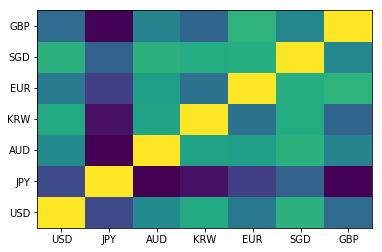

In [28]:
import numpy as np 
from pandas import DataFrame
import matplotlib.pyplot as plt

df = monthly_return.dropna().corr()
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)


In [29]:
from numpy.linalg import eig
h, v = eig(df)

In [30]:
h

array([3.96571756, 0.99506435, 0.80859621, 0.43133106, 0.30871688,
       0.22408052, 0.26649342])

In [31]:
w = v[:,0]
w.T.dot(df).dot(w)

3.9657175594593843

In [32]:
w

array([0.39483207, 0.18686479, 0.40725123, 0.38975669, 0.40409959,
       0.44751149, 0.35757844])

In [33]:
v[0]

array([ 0.39483207,  0.1528694 ,  0.37261786, -0.57741982,  0.52705722,
       -0.22547995,  0.14089125])

In [34]:
monthly_return.dropna().std()

USD    0.013579
JPY    0.028766
AUD    0.036338
KRW    0.030271
EUR    0.029229
SGD    0.015209
GBP    0.027049
dtype: float64

In [35]:
monthly_return.dropna().cov()

,USD,JPY,AUD,KRW,EUR,SGD,GBP
USD,0.000184,0.000122,0.000262,0.000267,0.000186,0.000140,0.000153
JPY,0.000122,0.000827,0.000116,0.000132,0.000231,0.000171,0.000090
AUD,0.000262,0.000116,0.001320,0.000690,0.000646,0.000376,0.000503
KRW,0.000267,0.000132,0.000690,0.000916,0.000392,0.000302,0.000326
EUR,0.000186,0.000231,0.000646,0.000392,0.000854,0.000294,0.000542
SGD,0.000140,0.000171,0.000376,0.000302,0.000294,0.000231,0.000215
GBP,0.000153,0.000090,0.000503,0.000326,0.000542,0.000215,0.000732


In [36]:
# Raw data
curncy_vix = all_vix[sigma_vix]
# Transform the data points
ps_score = percentile_score(curncy_vix, window_size=40)
chinorm = chi2normal_transformation(curncy_vix)

C:\Users\i6800309\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\i6800309\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\i6800309\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=150,center=False).mean()
  from ipykernel import kernelapp as app
C:\Users\i6800309\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
C:\Users\i6800309\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: inva

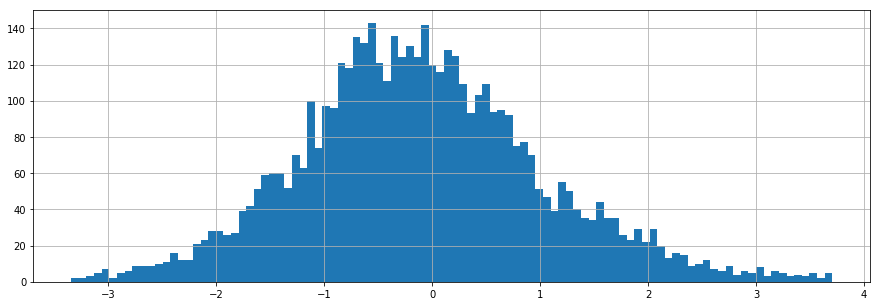

In [37]:
chinorm["EURUSDV1M Curncy"].hist(bins=100, **meta_setup)

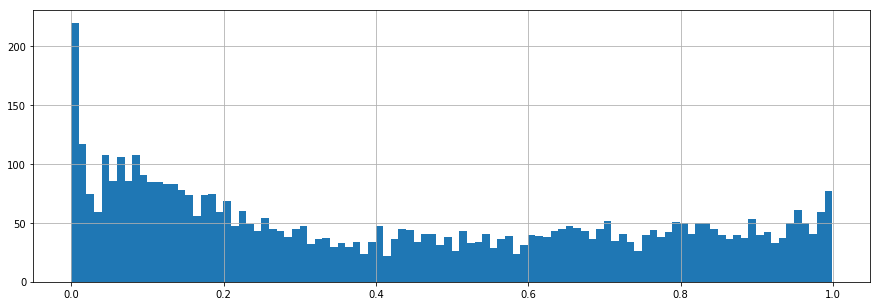

In [38]:
ps_score["EURUSDV1M Curncy"].hist(bins=100,**meta_setup)

In [ ]:
factor_target = pd.concat([monthly_return, ps_score], 1).dropna()
monthly_return = factor_target[monthly_return.columns]
risk_factor = factor_target[ps_score.columns]

In [128]:
for name in hist_weights.keys():
    m = hist_weights[name]
    weights_all = pd.DataFrame(m[1], index=pd.DatetimeIndex(m[0]), columns=monthly_return.columns[1:])
    weights_all.to_excel("./excels/{}.xlsx".format(name))

In [42]:
monthly_return.shape

(5183, 7)

In [45]:
monthly_return[:100].iloc[-1]

USD    0.002964
JPY    0.052484
AUD   -0.019036
KRW    0.008838
EUR    0.000282
SGD    0.008136
GBP    0.001736
Name: 1999-05-20 00:00:00, dtype: float64

In [47]:
monthly_return.iloc[100]

USD    0.000153
JPY    0.040302
AUD   -0.020535
KRW    0.003719
EUR   -0.000283
SGD    0.004736
GBP   -0.000684
Name: 1999-05-21 00:00:00, dtype: float64

In [127]:
# Return Test
# dynamic estimate the correlation matrix
from model.passive_model import BasketModel, FactorDynamicBasketModel, TVOLS
initial_size = 50
factor_target = pd.concat([monthly_return, ps_score], 1).dropna()
monthly_return = factor_target[monthly_return.columns]
risk_factor = factor_target[ps_score.columns]

portfolio = ["JPY", "AUD", "KRW", "XEU", "SGD", "GBP"]
target = "USD"

factor_maps = { 
    "JPY": ['USDJPYV1M Curncy'],
    "AUD": ['AUDUSDV1M Curncy', 'USDTWDV1M Curncy'],
    "KRW": ['USDKRWV1M Curncy', 'USDTWDV1M Curncy'],
    "XEU": ['EURUSDV1M Curncy'],
    "SGD": ['USDSGDV1M Curncy'],
    "GBP": ['USDTWDV1M Curncy']
                }
hist_weights = {}
agent1 = BasketModel(target="USD", 
                     portfolio=portfolio)

agent2 = FactorDynamicBasketModel(target="USD", 
                                  portfolio=portfolio, 
                                  factor_maps=factor_maps)
agent3 = TVOLS(target="USD", 
                     portfolio=portfolio)

agents = [agent1, agent2, agent3]

time_index = []
rewards_dy = []
weighs_dy = []
bound_dy = []
for agent in agents:
    r_temp = []
    w_temp = []
    stamp_temp = []
    b_temp = []
    for step in range(monthly_return.shape[0] - initial_size):
        # prepare data
        if agent.__class__.__name__ == "BasketModel":
            batch_return = monthly_return.iloc[:step + initial_size]
            agent.train(batch_return[agent._target], batch_return[agent._portfolio])
            weight = agent.weights
            
        elif agent.__class__.__name__ == "FactorDynamicBasketModel":
            batch_returns = monthly_return.iloc[:step + initial_size]
            batch_factor = risk_factor.iloc[:step + initial_size]
            proxy_list = agent.making_features(portfolio_returns=batch_return[agent._portfolio],
                                               factors=batch_factor)
            target_proxy = pd.concat([batch_returns, proxy_list], 1).dropna()
            agent.train(target_proxy[agent._target], target_proxy.drop(agent._target, 1))
            
        elif agent.__class__.__name__ == "TVOLS":
            batch_return = monthly_return.iloc[:step + initial_size]
            res = agent.fit(batch_return[agent._portfolio], batch_return[[agent._target]])
                
        # New data point
        new_state = monthly_return.iloc[step+initial_size]
        new_risk = risk_factor.iloc[:step+initial_size+1]
        proxy = new_state[agent._portfolio]
        target = new_state[agent._target]

        if agent.__class__.__name__ == "FactorDynamicBasketModel":
            w = agent.dynamic_weights(new_risk)
            weight = w.iloc[-1]
        elif agent.__class__.__name__ == "BasketModel":
            weight = agent._weights
        elif agent.__class__.__name__ == "TVOLS":
            weight = np.array(res[0])[-1]
        r = agent.reward(target, proxy, weight)
        #bound = agent.residual_bound(target, proxy, weight, norm.interval(0.68)[1])
        r_temp.append(r)
        w_temp.append(weight)
        stamp_temp.append(monthly_return.index[step+initial_size])
        #b_temp.append(bound)
    hist_weights[agent.__class__.__name__] = [stamp_temp, w_temp]

Text(0.5,1,'Monthly Accumulated Returns')

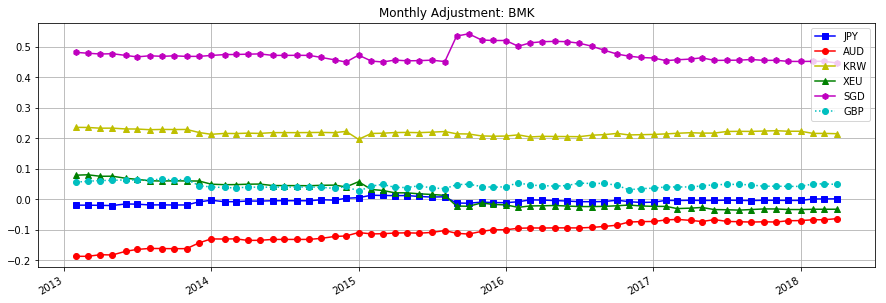

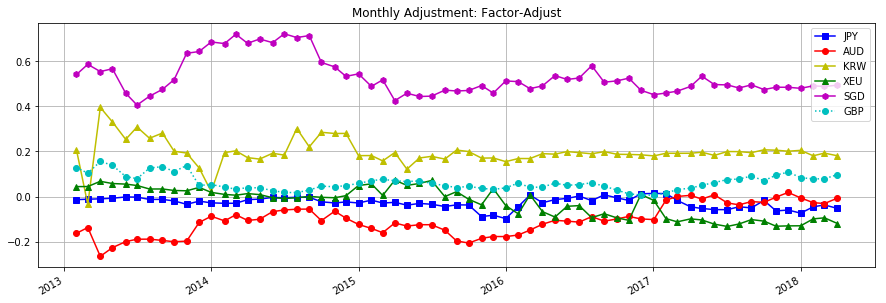

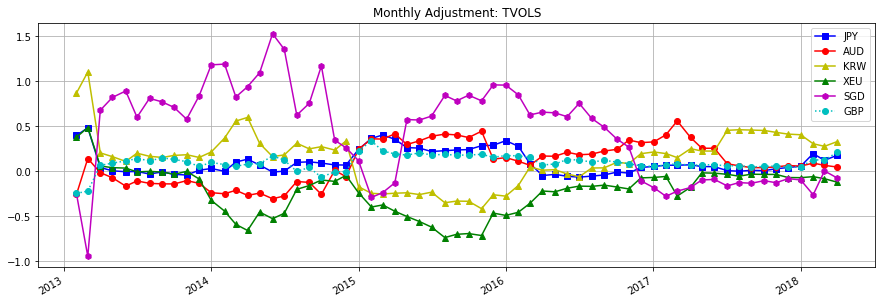

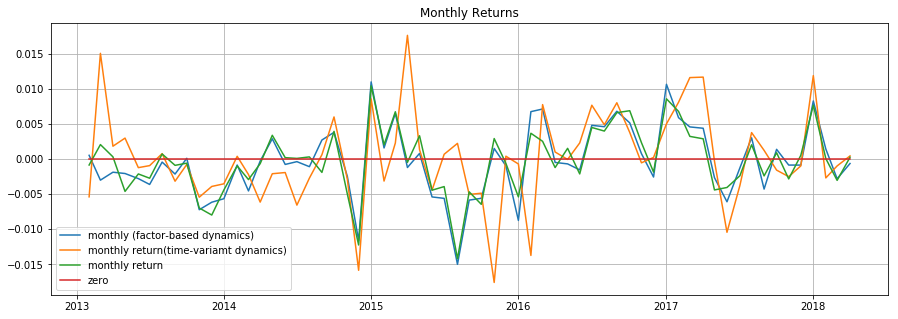

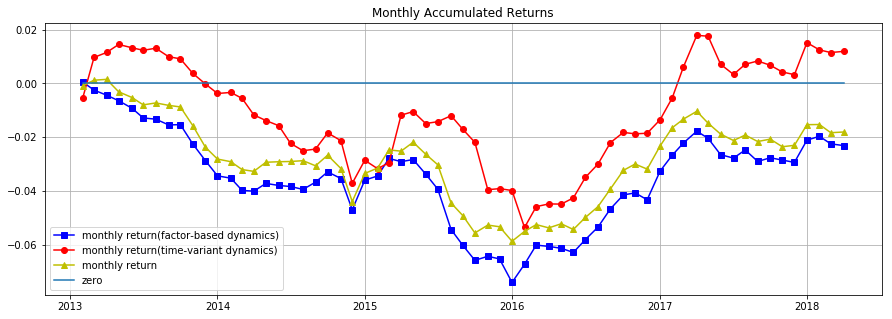

In [121]:
# Return Test
# dynamic estimate the correlation matrix
from model.passive_model import BasketModel, FactorDynamicBasketModel, TVOLS
initial_size = 50
factor_target = pd.concat([monthly_return, ps_score], 1).dropna()
monthly_return = factor_target[monthly_return.columns]
risk_factor = factor_target[ps_score.columns]

portfolio = ["JPY", "AUD", "KRW", "XEU", "SGD", "GBP"]
target = "USD"

factor_maps = { 
    "JPY": ['USDJPYV1M Curncy'],
    "AUD": ['AUDUSDV1M Curncy', 'USDTWDV1M Curncy'],
    "KRW": ['USDKRWV1M Curncy', 'USDTWDV1M Curncy'],
    "XEU": ['EURUSDV1M Curncy'],
    "SGD": ['USDSGDV1M Curncy'],
    "GBP": ['USDTWDV1M Curncy']
                }

agent1 = BasketModel(target="USD", 
                     portfolio=portfolio)

agent2 = FactorDynamicBasketModel(target="USD", 
                                  portfolio=portfolio, 
                                  factor_maps=factor_maps)
agent3 = TVOLS(target="USD", 
                     portfolio=portfolio)

agents = [agent1, agent2, agent3]

time_index = []
rewards_dy = []
weighs_dy = []
bound_dy = []

for step in range(monthly_return.shape[0] - initial_size):
    r_temp = []
    w_temp = []
    stamp_temp = []
    b_temp = []
    
    for agent in agents:
        # prepare data
        if agent.__class__.__name__ == "BasketModel":
            batch_return = monthly_return.iloc[:step + initial_size]
            agent.train(batch_return[agent._target], batch_return[agent._portfolio])
            weight = agent.weights
            
        elif agent.__class__.__name__ == "FactorDynamicBasketModel":
            batch_returns = monthly_return.iloc[:step + initial_size]
            batch_factor = risk_factor.iloc[:step + initial_size]
            proxy_list = agent.making_features(portfolio_returns=batch_return[agent._portfolio],
                                               factors=batch_factor)
            target_proxy = pd.concat([batch_returns, proxy_list], 1).dropna()
            agent.train(target_proxy[agent._target], target_proxy.drop(agent._target, 1))
            
        elif agent.__class__.__name__ == "TVOLS":
            batch_return = monthly_return.iloc[:step + initial_size]
            res = agent.fit(batch_return[agent._portfolio], batch_return[[agent._target]])
                
        # New data point
        new_state = monthly_return.iloc[step+initial_size]
        new_risk = risk_factor.iloc[:step+initial_size+1]
        proxy = new_state[agent._portfolio]
        target = new_state[agent._target]

        if agent.__class__.__name__ == "FactorDynamicBasketModel":
            w = agent.dynamic_weights(new_risk)
            weight = w.iloc[-1]
        elif agent.__class__.__name__ == "BasketModel":
            weight = agent._weights
        elif agent.__class__.__name__ == "TVOLS":
            weight = np.array(res[0])[-1]
        r = agent.reward(target, proxy, weight)
        #bound = agent.residual_bound(target, proxy, weight, norm.interval(0.68)[1])
        r_temp.append(r)
        w_temp.append(weight)
        stamp_temp.append(monthly_return.index[step])
        #b_temp.append(bound)
    time_index.append(monthly_return.index[step + initial_size])    
    rewards_dy.append(r_temp)
    weighs_dy.append(w_temp)
    bound_dy.append(b_temp)

styles = ['bs-','ro-','y^-', 'g^-', 'mh-', 'co:']
pd.DataFrame(np.array(weighs_dy)[:, 0, :], index=time_index, columns=portfolio).plot(
    title="Monthly Adjustment: BMK", style=styles, **meta_setup)    
pd.DataFrame(np.array(weighs_dy)[:, 1, :], index=time_index, columns=portfolio).plot(
    title="Monthly Adjustment: Factor-Adjust", style=styles, **meta_setup)
pd.DataFrame(np.array(weighs_dy)[:, 2, :], index=time_index, columns=portfolio).plot(
    title="Monthly Adjustment: TVOLS", style=styles, **meta_setup)
    
rewards_dy = np.array(rewards_dy)
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
plt.plot(time_index, rewards_dy[:, 1], 
         label='monthly (factor-based dynamics)')

plt.plot(time_index, rewards_dy[:, 2], 
         label='monthly return(time-variamt dynamics)')

plt.plot(time_index, rewards_dy[:, 0], 
         label='monthly return')

plt.plot(time_index, np.zeros_like(rewards_dy[:, 0]), label="zero")
#plt.plot(time_index, np.array(bound_dy)[:, 0, :].mean(1), label="res_mean")
#plt.fill_between(time_index, np.array(bound_dy)[:, 1, :][:, 0], np.array(bound_dy)[:, 1, :][:, 1], alpha=0.2)
#plt.fill_between(time_index, np.array(bound_dy)[:, 0, :][:, 0], np.array(bound_dy)[:, 0, :][:, 1], alpha=0.2)
plt.grid(True)
plt.legend()
plt.title("Monthly Returns")

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
plt.plot(time_index, np.cumsum(rewards_dy[:, 1]), styles[0], label='monthly return(factor-based dynamics)')
plt.plot(time_index, np.cumsum(rewards_dy[:, 2]), styles[1], label='monthly return(time-variant dynamics)')
plt.plot(time_index, np.cumsum(rewards_dy[:, 0]), styles[2], label='monthly return')
plt.plot(time_index, np.zeros_like(rewards_dy[:, 0]), label="zero")
#plt.plot(time_index, np.array(bound_dy)[:, 0, :].mean(1), label="res_mean")
#plt.fill_between(time_index, np.array(bound_dy)[:, 1, :][:, 0], np.array(bound_dy)[:, 1, :][:, 1], alpha=0.2)
#plt.fill_between(time_index, np.array(bound_dy)[:, 0, :][:, 0], np.array(bound_dy)[:, 0, :][:, 1], alpha=0.2)
plt.grid(True)
plt.legend()
plt.title("Monthly Accumulated Returns")

In [133]:
monthly_return.loc[pd.to_datetime("20130201")]

USD   -0.001247
JPY    0.005124
AUD   -0.017743
KRW    0.008552
XEU   -0.041786
SGD    0.001291
GBP   -0.043717
Name: 2013-02-01 00:00:00, dtype: float64

In [132]:
monthly_return.loc[pd.to_datetime("20130301")]

USD   -0.007045
JPY   -0.013179
AUD    0.020682
KRW   -0.023009
XEU   -0.016421
SGD   -0.001450
GBP    0.010304
Name: 2013-03-01 00:00:00, dtype: float64

Text(0.5,1,'Weekly Accumulated Returns')

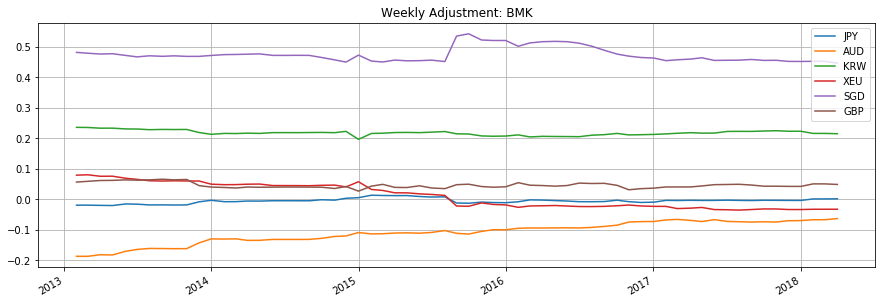

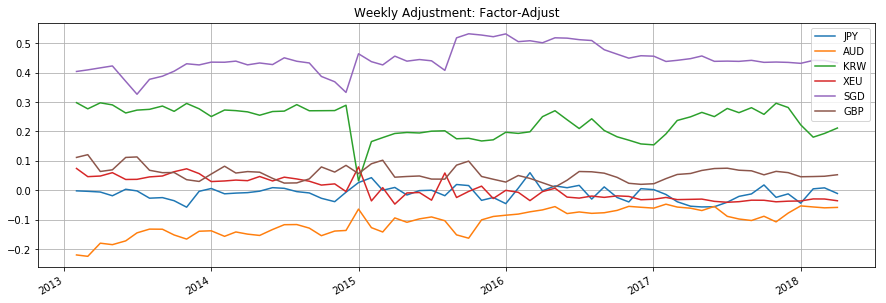

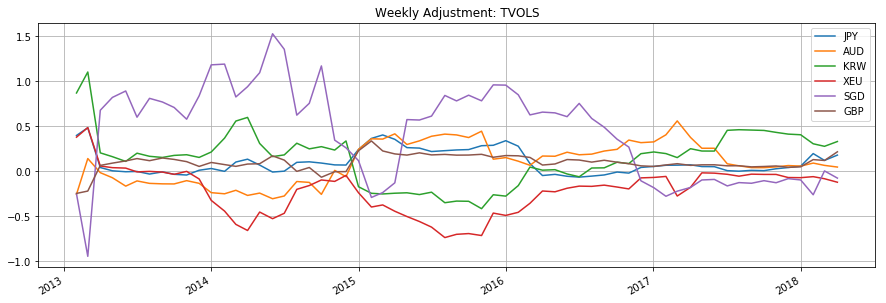

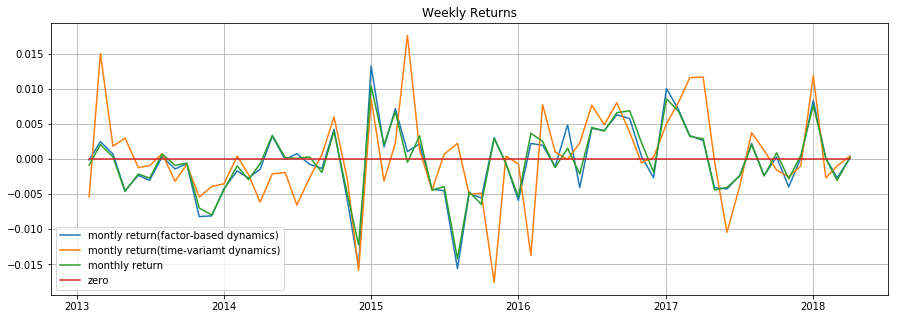

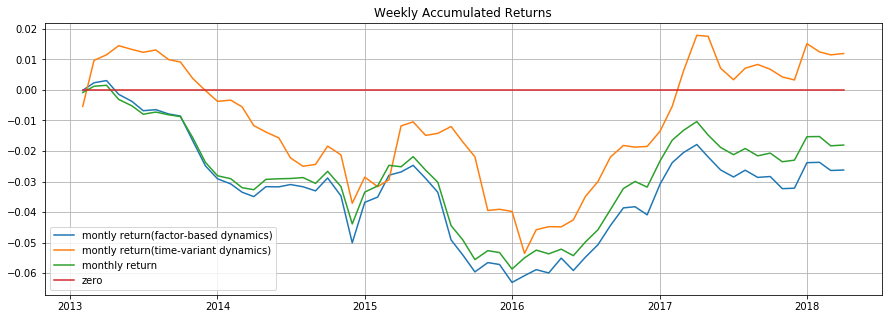

In [123]:
# Return Test
# dynamic estimate the correlation matrix
from model.passive_model import BasketModel, FactorDynamicBasketModel, TVOLS
initial_size = 50
factor_target = pd.concat([monthly_return, chinorm], 1).dropna()
monthly_return = factor_target[monthly_return.columns]
risk_factor = factor_target[ps_score.columns]

portfolio = ["JPY", "AUD", "KRW", "XEU", "SGD", "GBP"]
target = "USD"

factor_maps = { 
    "JPY": ['USDJPYV1M Curncy'],
    "AUD": ['AUDUSDV1M Curncy', 'USDTWDV1M Curncy'],
    "KRW": ['USDKRWV1M Curncy', 'USDTWDV1M Curncy'],
    "XEU": ['EURUSDV1M Curncy'],
    "SGD": ['USDSGDV1M Curncy'],
    "GBP": ['USDTWDV1M Curncy']
                }

agent1 = BasketModel(target="USD", 
                     portfolio=portfolio)

agent2 = FactorDynamicBasketModel(target="USD", 
                                  portfolio=portfolio, 
                                  factor_maps=factor_maps)
agent3 = TVOLS(target="USD", 
                     portfolio=portfolio)

agents = [agent1, agent2, agent3]

time_index = []
rewards_dy = []
weighs_dy = []
bound_dy = []

for step in range(monthly_return.shape[0] - initial_size):
    r_temp = []
    w_temp = []
    b_temp = [] 
    for agent in agents:
        # prepare data
        if agent.__class__.__name__ == "BasketModel":
            batch_return = monthly_return.iloc[:step + initial_size]
            agent.train(batch_return[agent._target], batch_return[agent._portfolio])
            weight = agent.weights
            
        elif agent.__class__.__name__ == "FactorDynamicBasketModel":
            batch_returns = monthly_return.iloc[:step + initial_size]
            batch_factor = risk_factor.iloc[:step + initial_size]
            proxy_list = agent.making_features(portfolio_returns=batch_return[agent._portfolio],
                                               factors=batch_factor)
            target_proxy = pd.concat([batch_returns, proxy_list], 1).dropna()
            agent.train(target_proxy[agent._target], target_proxy.drop(agent._target, 1))
            
        elif agent.__class__.__name__ == "TVOLS":
                batch_return = monthly_return.iloc[:step + initial_size]
                res = agent.fit(batch_return[agent._portfolio], batch_return[[agent._target]])
                

        new_state = monthly_return.iloc[step+initial_size]
        new_risk = risk_factor.iloc[:step+initial_size+1]
        proxy = new_state[agent._portfolio]
        target = new_state[agent._target]

        if agent.__class__.__name__ == "FactorDynamicBasketModel":
            w = agent.dynamic_weights(new_risk)
            weight = w.iloc[-1]
            
        elif agent.__class__.__name__ == "BasketModel":
            weight = agent._weights
            
        elif agent.__class__.__name__ == "TVOLS":
            weight = np.array(res[0])[-1]
            
        r = agent.reward(target, proxy, weight)
        # bound = agent.residual_bound(target, proxy, weight, norm.interval(0.68)[1])
        r_temp.append(r)
        w_temp.append(weight)
        # b_temp.append(bound)
        
    time_index.append(monthly_return.index[step + initial_size])    
    rewards_dy.append(r_temp)
    weighs_dy.append(w_temp)
    bound_dy.append(b_temp)
    
pd.DataFrame(np.array(weighs_dy)[:, 0, :], index=time_index, columns=portfolio).plot(title="Weekly Adjustment: BMK", 
                                                                                     **meta_setup)    
pd.DataFrame(np.array(weighs_dy)[:, 1, :], index=time_index, columns=portfolio).plot(title="Weekly Adjustment: Factor-Adjust", 
                                                                                     **meta_setup)
pd.DataFrame(np.array(weighs_dy)[:, 2, :], index=time_index, columns=portfolio).plot(title="Weekly Adjustment: TVOLS", 
                                                                                     **meta_setup)
rewards_dy = np.array(rewards_dy)
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
plt.plot(time_index, rewards_dy[:, 1], label='montly return(factor-based dynamics)')
plt.plot(time_index, rewards_dy[:, 2], label='montly return(time-variamt dynamics)')
plt.plot(time_index, rewards_dy[:, 0], label='monthly return')
#plt.plot(time_index, np.array(bound_dy)[:, 0, :].mean(1), label="res_mean")
plt.plot(time_index, np.zeros_like(rewards_dy[:, 0]), label="zero")
#plt.fill_between(time_index, np.array(bound_dy)[:, 1, :][:, 0], np.array(bound_dy)[:, 1, :][:, 1], alpha=0.2)
#plt.fill_between(time_index, np.array(bound_dy)[:, 0, :][:, 0], np.array(bound_dy)[:, 0, :][:, 1], alpha=0.2)
plt.grid(True)
plt.legend()
plt.title("Weekly Returns")

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
plt.plot(time_index, np.cumsum(rewards_dy[:, 1]), label='montly return(factor-based dynamics)')
plt.plot(time_index, np.cumsum(rewards_dy[:, 2]), label='montly return(time-variant dynamics)')
plt.plot(time_index, np.cumsum(rewards_dy[:, 0]), label='monthly return')
plt.plot(time_index, np.zeros_like(rewards_dy[:, 0]), label="zero")
#plt.fill_between(time_index, np.array(bound_dy)[:, 1, :][:, 0], np.array(bound_dy)[:, 1, :][:, 1], alpha=0.2)
#plt.fill_between(time_index, np.array(bound_dy)[:, 0, :][:, 0], np.array(bound_dy)[:, 0, :][:, 1], alpha=0.2)
plt.grid(True)
plt.legend()
plt.title("Weekly Accumulated Returns")

In [13]:
weights = np.array(weighs_dy)
bmk_weights = weights[:, 0, :]
factor_adj_weights = weights[:, 1, :]
tvols_weights = weights[:, 2, :] 

In [14]:
monthly_return.describe()

,USD,JPY,AUD,KRW,XEU,SGD,GBP
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,-0.000866,-0.000811,-0.001323,-0.000611,-0.001380,-0.001587,0.000430
std,0.014062,0.027647,0.038525,0.034022,0.029724,0.017309,0.027639
min,-0.038068,-0.066793,-0.099255,-0.126756,-0.097975,-0.062496,-0.088745
25%,-0.008142,-0.018586,-0.026003,-0.018123,-0.017873,-0.012736,-0.018804
50%,-0.000519,-0.001264,-0.001843,-0.004725,-0.004206,-0.001984,0.000225
75%,0.007127,0.015633,0.016761,0.012800,0.013909,0.007470,0.016022
max,0.056181,0.091870,0.176315,0.141548,0.101996,0.088736,0.098453


In [15]:
from sklearn.tree import DecisionTreeRegressor
monthly_return.describe()
model = DecisionTreeRegressor(min_samples_leaf=30)
model.fit(monthly_return[portfolio], monthly_return['USD'])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=30,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [16]:
# transform the decision tree into linear regression's functional form
# calculate the depth of the Tree
right_nodes = model.tree_.children_right
left_nodes = model.tree_.children_left
y_hat_all = model.tree_.value[:, 0].flatten()
features_all = model.tree_.feature # The root node do not have any feature to decide on.
number_of_node = len(model.tree_.children_left)
beta = np.zeros(shape=number_of_node)
features_maps = []
beta[0] = y_hat_all[0]

for i in range(number_of_node):
    left_node_id = left_nodes[i]
    right_node_id = right_nodes[i]
    features_maps.append(features_all[i])
    coef_r = y_hat_all[right_node_id] - y_hat_all[i] 
    coef_l = y_hat_all[left_node_id] - y_hat_all[i]
    beta[right_node_id] = coef_r
    beta[left_node_id] = coef_l

In [48]:
feature_maps = []
for i in range(len(portfolio)):
    for id_ in range(number_of_node):
        if features_all[id_] == i:
            left_node_id = left_nodes[id_]
            right_node_id = right_nodes[id_]
            feature_maps.append((left_node_id, right_node_id))

In [49]:
feature_maps

[(6, 7), (2, 3), (1, 4), (5, 8)]

In [60]:
def decision_postion(portfolio, model, beta, feature_maps):
    path_matrix = model.decision_path(portfolio)[0].nonzero()[1]
    colums_activate = []
    print(path_matrix)

In [61]:
monthly_return[portfolio].values[0:1, :]

array([[-0.00329021, -0.03255988,  0.00033973, -0.00652398,  0.00780781,
        -0.00476391]])

In [62]:
decision_postion(monthly_return[portfolio].values[0:1, :], model, beta, feature_maps)

[0 4 5 7]


In [41]:
m = model.decision_path(monthly_return[portfolio]).nonzero()

In [33]:
m = DecisionTreeRegressor()

IndexError: index out of bounds: 0 <= 1 <= 1, 0 <= 2 <= 1, 1 <= 2

In [ ]:
for agent in agents:
    